In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np
from sklearn.model_selection import train_test_split
import category_encoders as ce
import scipy.stats as stats
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
import shap
from sklearn.model_selection import KFold
from sklearn.tree import plot_tree




%matplotlib inline

### k_NN for the datasets containing the extreme values:

In [2]:
#cleaned dataset
df = pd.read_csv("auto_data_cleaned_16_09_2024.csv")

# the models will be encoded by mean value of price of every model
target_encoder = ce.TargetEncoder(cols=['model'])
df['Modell_encoded'] = target_encoder.fit_transform(df['model'], df['price_in_euro'])  # 'Preis' ist die Zielvariable


# the brand will be encoded by mean value of price of every model
target_encoder = ce.TargetEncoder(cols=['brand'])
df['Brand_encoded'] = target_encoder.fit_transform(df['brand'], df['price_in_euro'])  # 'Preis' ist die Zielvariable

df=df.drop(columns=['year','offer_description' ])

df = pd.get_dummies(df, columns=[ 'fuel_type', 'transmission_type','color'], dtype='int')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238302 entries, 0 to 238301
Data columns (total 36 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   brand                             238302 non-null  object 
 1   model                             238302 non-null  object 
 2   price_in_euro                     238302 non-null  float64
 3   power_ps                          238302 non-null  float64
 4   fuel_consumption_l_100km          238302 non-null  float64
 5   mileage_in_km                     238302 non-null  float64
 6   age                               238302 non-null  float64
 7   Modell_encoded                    238302 non-null  float64
 8   Brand_encoded                     238302 non-null  float64
 9   fuel_type_CNG                     238302 non-null  int64  
 10  fuel_type_Diesel                  238302 non-null  int64  
 11  fuel_type_Diesel Hybrid           238302 non-null  i

In [3]:
#cleaned dropped dataset
df_drop = pd.read_csv("auto_data_cleaned_drop__15_10_2024.csv")


# the models will be encoded by mean value of price of every model
target_encoder = ce.TargetEncoder(cols=['model'])
df_drop['Modell_encoded'] = target_encoder.fit_transform(df['model'], df['price_in_euro'])  # 'Preis' ist die Zielvariable


# the brand will be encoded by mean value of price of every model
target_encoder = ce.TargetEncoder(cols=['brand'])
df_drop['Brand_encoded'] = target_encoder.fit_transform(df['brand'], df['price_in_euro'])  # 'Preis' ist die Zielvariable

df_drop=df_drop.drop(columns=['year','offer_description'])

df_drop = pd.get_dummies(df_drop, columns=[ 'fuel_type', 'transmission_type','color'], dtype='int')
df_drop.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213668 entries, 0 to 213667
Data columns (total 36 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   brand                             213668 non-null  object 
 1   model                             213668 non-null  object 
 2   price_in_euro                     213668 non-null  float64
 3   power_ps                          213668 non-null  float64
 4   fuel_consumption_l_100km          213668 non-null  float64
 5   mileage_in_km                     213668 non-null  float64
 6   age                               213668 non-null  float64
 7   Modell_encoded                    213668 non-null  float64
 8   Brand_encoded                     213668 non-null  float64
 9   fuel_type_CNG                     213668 non-null  int64  
 10  fuel_type_Diesel                  213668 non-null  int64  
 11  fuel_type_Diesel Hybrid           213668 non-null  i

In [4]:
# Splitting the data into training and test sets
X = df.drop(['price_in_euro', 'model', 'brand'], axis=1)  # Features
y = df['price_in_euro']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Splitting the data into training and test sets
X_d = df_drop.drop(['price_in_euro', 'model', 'brand'], axis=1)  # Features
y_d = df_drop['price_in_euro']  # Target variable

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d, y_d, test_size=0.2, random_state=42)


In [5]:
# Initialize the model with default parameters
dt = DecisionTreeRegressor(max_depth=20)
# Train the model
dt.fit(X_train, y_train)

#  Evaluate the model on the Test Set
y_pred = dt.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)
mse_test = mean_squared_error(y_test, y_pred)

print(f"Test MAE - full dataset: {test_mae}")
print(f"Test Set MSE - full dataset: {mse_test}")
print(f"Test R² - full dataset: {test_r2}")

# Initialize the model with default parameters
dt_d = DecisionTreeRegressor(max_depth=None)
# Train the model
dt_d.fit(X_train_d, y_train_d)

#  Evaluate the model on the Test Set
y_pred_d = dt_d.predict(X_test_d)
test_mae_d = mean_absolute_error(y_test_d, y_pred_d)
test_r2_d = r2_score(y_test_d, y_pred_d)
mse_test_d = mean_squared_error(y_test_d, y_pred_d)

print(f"Test MAE - dropped dataset: {test_mae_d}")
print(f"Test Set MSE - drop dataset: {mse_test_d}")
print(f"Test R² - dropped dataset: {test_r2_d}")


Test MAE - full dataset: 4314.831586271573
Test Set MSE - full dataset: 348406851.6354242
Test R² - full dataset: 0.692446218157151
Test MAE - dropped dataset: 5027.318085911296
Test Set MSE - drop dataset: 284735751.7925745
Test R² - dropped dataset: 0.7076657003778659


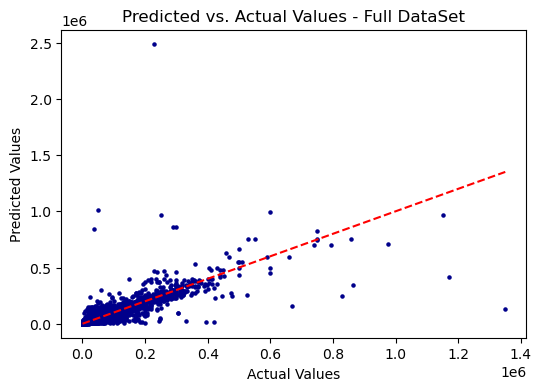

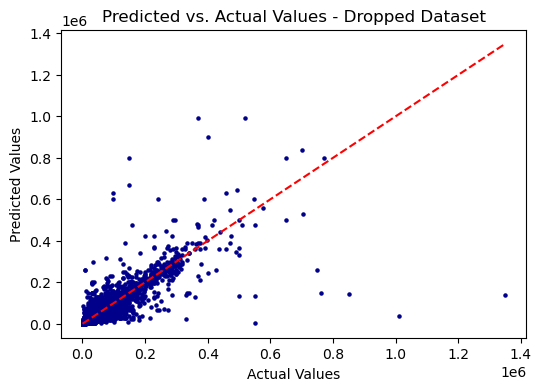

In [6]:
# Plot Predicted vs. Actual Values
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred, s=5, color='darkblue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Diagonal line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values - Full DataSet')
plt.show()

# Plot Predicted vs. Actual Values
plt.figure(figsize=(6,4))
plt.scatter(y_test_d, y_pred_d, s=5, color='darkblue')
plt.plot([min(y_test_d), max(y_test_d)], [min(y_test_d), max(y_test_d)], 'r--')  # Diagonal line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values - Dropped Dataset')
plt.show()


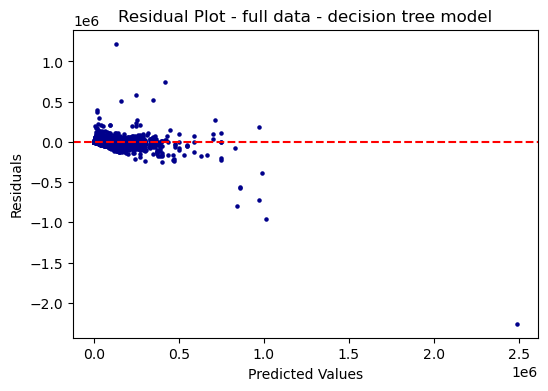

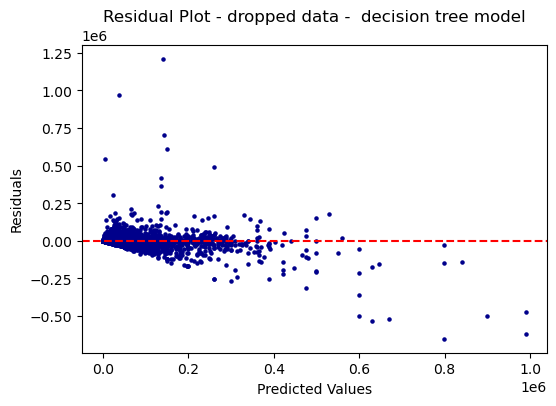

In [8]:
# Plot Residuals
residuals = y_test - y_pred
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, s = 5, color='darkblue')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot - full data - decision tree model')
plt.show()

# Plot Residuals
residuals = y_test_d - y_pred_d
plt.figure(figsize=(6,4))
plt.scatter(y_pred_d, residuals, s = 5, color='darkblue')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot - dropped data -  decision tree model')
plt.show()

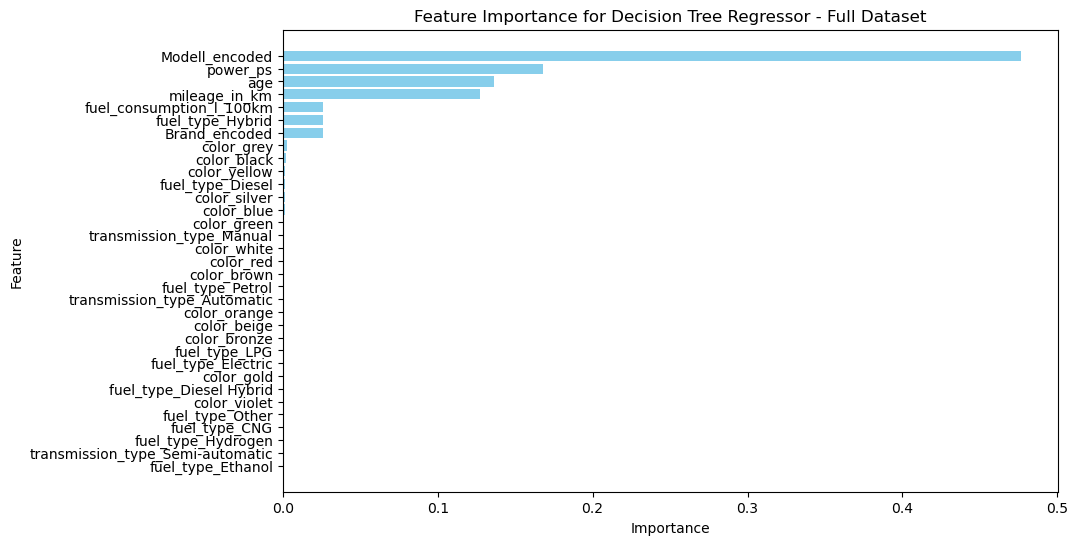

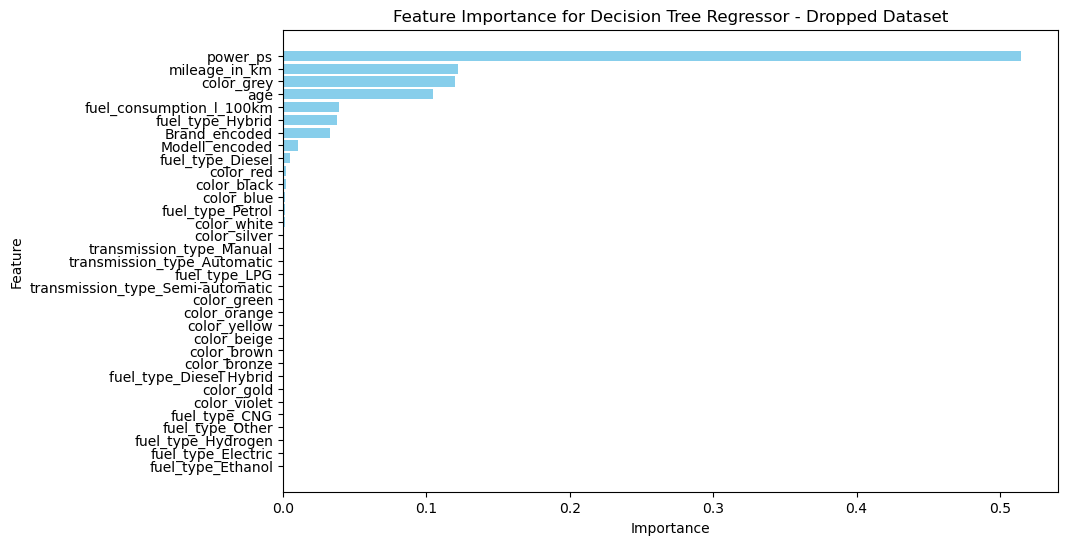

In [7]:
# Get feature importances from the model
feature_importances = dt.feature_importances_

# Create a DataFrame for easy plotting

# Assuming X_train has the same columns as the data you trained
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Decision Tree Regressor - Full Dataset')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.show()


# Get feature importances from the model
feature_importances_d = dt_d.feature_importances_

# Create a DataFrame for easy plotting

# Assuming X_train has the same columns as the data you trained
feature_names = X_train_d.columns
importance_df_d = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances_d
})

# Sort by importance
importance_df_d = importance_df_d.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df_d['Feature'], importance_df_d['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Decision Tree Regressor - Dropped Dataset')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.show()

### Fine-tuning with GridSearchCV:

In [12]:
# Initialize the model with default parameters
dt = DecisionTreeRegressor(max_depth=20)

param_grid = {
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
   # 'criterion': ['absolute_error', 'squared_error']
}


# Set up GridSearchCV with KNN Regressor and 5-fold cross-validation
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

# Fit the model
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

# Get the best model
best_dt_regressor = grid_search.best_estimator_

# Predict using the best estimator
y_pred = best_dt_regressor.predict(X_test)



# Calculate the R² score
r2 = r2_score(y_test, y_pred)

# Print the R² score
print(f"R² Score - Full data: {r2:.4f}")
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

# Calculate metrics on the original scale
mse_test = mean_squared_error(y_test, y_pred)
mae_test = mean_absolute_error(y_test, y_pred)
print(f"Test Set MSE - Full data: {mse_test}")
print(f"Test Set MAE - full data: {mae_test}")
print(f"Test RMSE: {rmse:.2f}")

Best Parameters: {'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
R² Score - Full data: 0.7511
Test Set MSE - Full data: 281918573.68899405
Test Set MAE - full data: 4061.872409999861
Test RMSE: 16790.43


In [14]:
# Initialize the model with default parameters
dt = DecisionTreeRegressor( max_depth=None)

param_grid = {
    
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    #'criterion': ['absolute_error', 'squared_error']
}


# Set up GridSearchCV with KNN Regressor and 5-fold cross-validation
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

# Fit the model
grid_search.fit(X_train_d, y_train_d)

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

# Get the best model
best_dt_regressor = grid_search.best_estimator_

# Predict using the best estimator
y_pred_d = best_dt_regressor.predict(X_test_d)



# Calculate the R² score
r2 = r2_score(y_test_d, y_pred_d)

# Print the R² score
print(f"R² Score - Dropped data: {r2:.4f}")
# Evaluate the model
mse = mean_squared_error(y_test_d, y_pred_d)
rmse = mse ** 0.5

# Calculate metrics on the original scale
mse_test = mean_squared_error(y_test_d, y_pred_d)
mae_test = mean_absolute_error(y_test_d, y_pred_d)
print(f"Test Set MSE - Dropped data: {mse_test}")
print(f"Test Set MAE - Dropped data: {mae_test}")
print(f"Test RMSE: {rmse:.2f}")

Best Parameters: {'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
R² Score - Dropped data: 0.7233
Test Set MSE - Dropped data: 269526385.83652604
Test Set MAE - Dropped data: 4540.462593435137
Test RMSE: 16417.26


## Datasets without outliers:

In [9]:
#cleaned dataset
df = pd.read_csv("auto_data_cleaned_16_09_2024.csv")

# the models will be encoded by mean value of price of every model
target_encoder = ce.TargetEncoder(cols=['model'])
df['Modell_encoded'] = target_encoder.fit_transform(df['model'], df['price_in_euro'])  # 'Preis' ist die Zielvariable


# the brand will be encoded by mean value of price of every model
target_encoder = ce.TargetEncoder(cols=['brand'])
df['Brand_encoded'] = target_encoder.fit_transform(df['brand'], df['price_in_euro'])  # 'Preis' ist die Zielvariable

df=df.drop(columns=['year', 'offer_description', ])

df = pd.get_dummies(df, columns=[ 'fuel_type', 'transmission_type','color'], dtype='int')


# Remove outliers using Z-score for price and mileage
df_clean = df[(np.abs(stats.zscore(df['price_in_euro'])) < 5)]  # 5 is the higher threshold for outliers
df_clean = df_clean[(np.abs(stats.zscore(df_clean['mileage_in_km'])) < 4)]  # Do the same for mileage



In [10]:
#cleaned dropped dataset
df_drop = pd.read_csv("auto_data_cleaned_drop__15_10_2024.csv")


# the models will be encoded by mean value of price of every model
target_encoder = ce.TargetEncoder(cols=['model'])
df_drop['Modell_encoded'] = target_encoder.fit_transform(df['model'], df['price_in_euro'])  # 'Preis' ist die Zielvariable


# the brand will be encoded by mean value of price of every model
target_encoder = ce.TargetEncoder(cols=['brand'])
df_drop['Brand_encoded'] = target_encoder.fit_transform(df['brand'], df['price_in_euro'])  # 'Preis' ist die Zielvariable

df_drop=df_drop.drop(columns=['year', 'offer_description'])

df_drop = pd.get_dummies(df_drop, columns=[ 'fuel_type', 'transmission_type','color'], dtype='int')

# Remove outliers using Z-score for price and mileage
df_clean_d = df_drop[(np.abs(stats.zscore(df_drop['price_in_euro'])) < 5)]  # 4 is the higher threshold for outliers
df_clean_d = df_clean_d[(np.abs(stats.zscore(df_clean_d['mileage_in_km'])) < 4)]  # Do the same for mileage




In [11]:
# Splitting the data into training and test sets
X = df_clean.drop(['price_in_euro', 'model', 'brand'], axis=1)  # Features
y = df_clean['price_in_euro']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Splitting the data into training and test sets
X_d = df_clean_d.drop(['price_in_euro', 'model', 'brand'], axis=1)  # Features
y_d = df_clean_d['price_in_euro']  # Target variable

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d, y_d, test_size=0.2, random_state=42)

In [12]:
# Initialize the model with default parameters
dt = DecisionTreeRegressor(max_depth=10)
# Train the model
dt.fit(X_train, y_train)

# Step 4: Evaluate the model on the Test Set
y_pred = dt.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)
mse_test = mean_squared_error(y_test, y_pred)

print(f"Test MAE - full dataset: {test_mae}")
print(f"Test Set MSE - full dataset: {mse_test}")
print(f"Test R² - full dataset: {test_r2}")

# Initialize the model with default parameters
dt_d = DecisionTreeRegressor(max_depth=10)
# Train the model
dt_d.fit(X_train_d, y_train_d)

# Step 4: Evaluate the model on the Test Set
y_pred_d = dt_d.predict(X_test_d)
test_mae_d = mean_absolute_error(y_test_d, y_pred_d)
test_r2_d = r2_score(y_test_d, y_pred_d)
mse_test_d = mean_squared_error(y_test_d, y_pred_d)

print(f"Test MAE - dropped dataset: {test_mae_d}")
print(f"Test Set MSE - drop dataset: {mse_test_d}")
print(f"Test R² - dropped dataset: {test_r2_d}")


Test MAE - full dataset: 3941.9545442811773
Test Set MSE - full dataset: 55352928.59732126
Test R² - full dataset: 0.8700869111844343
Test MAE - dropped dataset: 4185.173137052042
Test Set MSE - drop dataset: 61327804.182387844
Test R² - dropped dataset: 0.8480657157214022


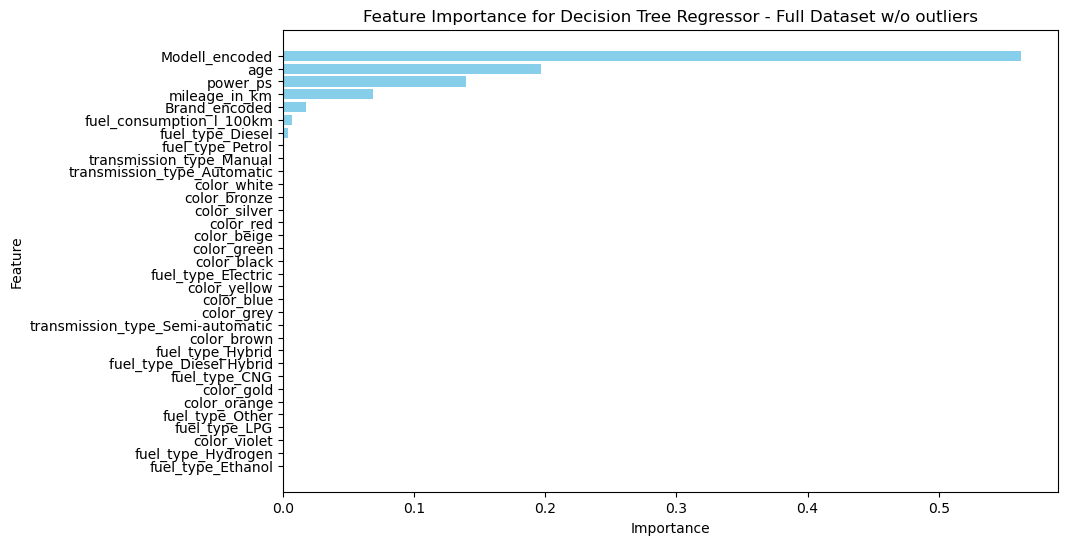

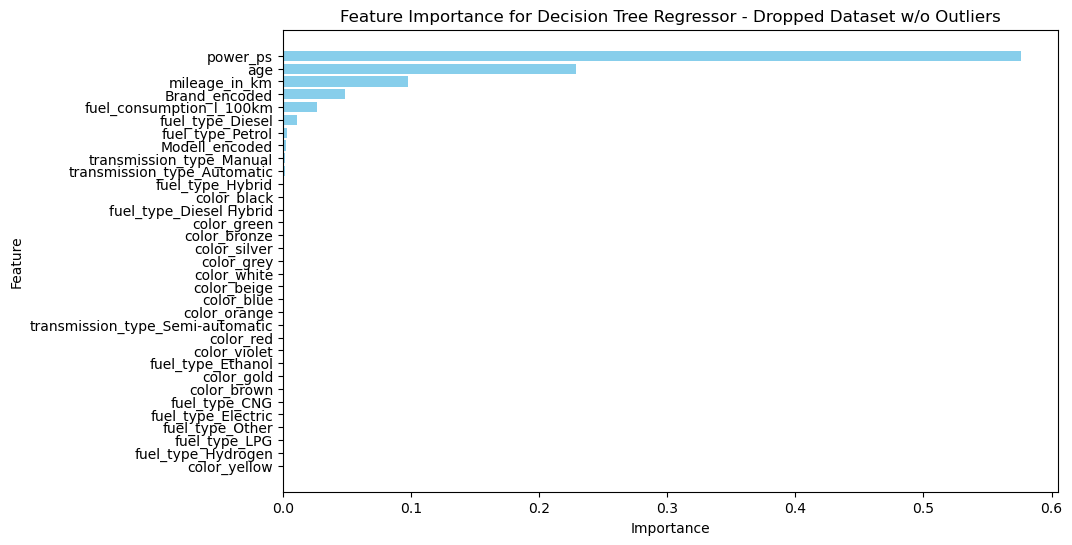

In [13]:
# Get feature importances from the model
feature_importances = dt.feature_importances_

# Create a DataFrame for easy plotting

# Assuming X_train has the same columns as the data you trained
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Decision Tree Regressor - Full Dataset w/o outliers')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.show()


# Get feature importances from the model
feature_importances_d = dt_d.feature_importances_

# Create a DataFrame for easy plotting

# Assuming X_train has the same columns as the data you trained
feature_names = X_train_d.columns
importance_df_d = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances_d
})

# Sort by importance
importance_df_d = importance_df_d.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df_d['Feature'], importance_df_d['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Decision Tree Regressor - Dropped Dataset w/o Outliers')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.show()

### Fine-tuning with Gridsearch CV:

In [50]:
# Initialize the model with default parameters
dt = DecisionTreeRegressor(max_depth=10)

param_grid = {
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
   # 'criterion': ['absolute_error', 'squared_error']
}


# Set up GridSearchCV with KNN Regressor and 5-fold cross-validation
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

# Fit the model
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

# Get the best model
best_dt_regressor = grid_search.best_estimator_

# Predict using the best estimator
y_pred = best_dt_regressor.predict(X_test)



# Calculate the R² score
r2 = r2_score(y_test, y_pred)

# Print the R² score
print(f"R² Score - Full data: {r2:.4f}")
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

# Calculate metrics on the original scale
mse_test = mean_squared_error(y_test, y_pred)
mae_test = mean_absolute_error(y_test, y_pred)
print(f"Test Set MSE - Full data: {mse_test}")
print(f"Test Set MAE - full data: {mae_test}")
print(f"Test RMSE: {rmse:.2f}")

Best Parameters: {'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
R² Score - Full data: 0.8722
Test Set MSE - Full data: 54431591.48751089
Test Set MAE - full data: 3918.405703867589
Test RMSE: 7377.78


In [51]:
# Initialize the model with default parameters
dt = DecisionTreeRegressor(max_depth=10)

param_grid = {
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
   # 'criterion': ['absolute_error', 'squared_error']
}


# Set up GridSearchCV with KNN Regressor and 5-fold cross-validation
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

# Fit the model
grid_search.fit(X_train_d, y_train_d)

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

# Get the best model
best_dt_regressor = grid_search.best_estimator_

# Predict using the best estimator
y_pred = best_dt_regressor.predict(X_test_d)



# Calculate the R² score
r2 = r2_score(y_test_d, y_pred)

# Print the R² score
print(f"R² Score - Dropped data: {r2:.4f}")
# Evaluate the model
mse = mean_squared_error(y_test_d, y_pred)
rmse = mse ** 0.5

# Calculate metrics on the original scale
mse_test = mean_squared_error(y_test_d, y_pred)
mae_test = mean_absolute_error(y_test_d, y_pred)
print(f"Test Set MSE - Dropped data: {mse_test}")
print(f"Test Set MAE - Dropped data: {mae_test}")
print(f"Test RMSE: {rmse:.2f}")

Best Parameters: {'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
R² Score - Dropped data: 0.8502
Test Set MSE - Dropped data: 60468882.37454774
Test Set MAE - Dropped data: 4171.421237861051
Test RMSE: 7776.17


In [14]:
# Initialize the model with best parameters
dt = DecisionTreeRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=5, max_features=None )
# Train the model
dt.fit(X_train, y_train)

#  Evaluate the model on the Test Set
y_pred = dt.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)
mse_test = mean_squared_error(y_test, y_pred)

print(f"Test MAE - full dataset: {test_mae}")
print(f"Test Set MSE - full dataset: {mse_test}")
print(f"Test R² - full dataset: {test_r2}")


# Step 4: Evaluate the model on the Test Set
y_pred_train = dt.predict(X_train)
train_mae = mean_absolute_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)

print(f"Train MAE - full dataset: {train_mae}")
print(f"Train Set MSE - full dataset: {mse_train}")
print(f"Train R² - full dataset: {train_r2}")

Test MAE - full dataset: 3916.245942738447
Test Set MSE - full dataset: 54424768.72109605
Test R² - full dataset: 0.8722652984801144
Train MAE - full dataset: 3736.75196125488
Train Set MSE - full dataset: 45294723.50185216
Train R² - full dataset: 0.8945591914727448


In [22]:
# Define the cross-validation strategy (5-Fold in this case)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
r2_scores = cross_val_score(dt, X, y, cv=cv, scoring='r2')
# Print the R² scores for each fold
print(f'R² scores for each fold: {r2_scores}')

# Compute the mean and standard deviation of the R² scores
print(f'Mean Cross-Validated R²: {r2_scores.mean():.4f}')
print(f'Standard Deviation of Cross-Validated R²: {r2_scores.std():.4f}')

R² scores for each fold: [0.86999932 0.87742933 0.86909528 0.87284504 0.86482646]
Mean Cross-Validated R²: 0.8708
Standard Deviation of Cross-Validated R²: 0.0042


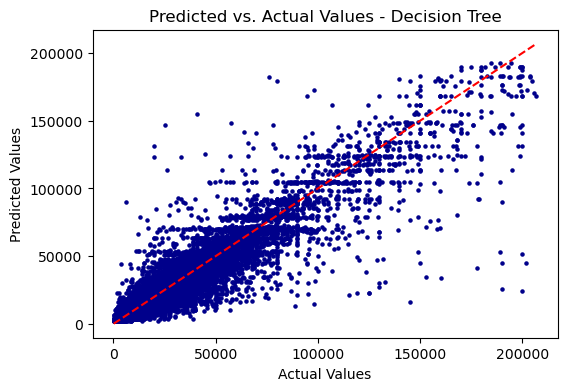

In [19]:
# Plot Predicted vs. Actual Values
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred, s=5, color='darkblue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Diagonal line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values - Decision Tree')
plt.show()

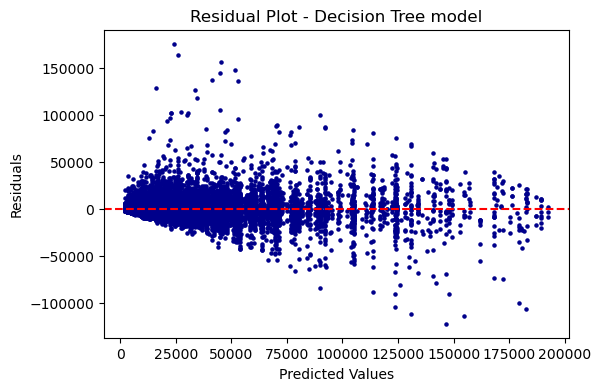

In [17]:
# Plot Residuals
residuals = y_test - y_pred
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, s = 5, color='darkblue')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot - Decision Tree model')
plt.show()

In [20]:
###  Now we will use the scaled version of Modell_encoded for the merge
# Prepare DataFrame for comparison
comparison_df = pd.DataFrame({
    'Actual Price': y_test,               
    'Predicted Price': y_pred,
    'Year' :2024 -  X_test['age'],
    'Power': X_test['power_ps'],
    'Mileage': X_test['mileage_in_km'],
    'Modell_encoded': X_test['Modell_encoded']  
})

#  Extract the original 'model' names from df_clean, including the scaled Modell_encoded
models_df = df_clean[['Modell_encoded', 'model']].drop_duplicates()  # Ensure unique Modell_encoded_scaled values

#  Merge the comparison DataFrame with models_df based on 'Modell_encoded_scaled'
final_comparison_df = pd.merge(comparison_df, models_df, on='Modell_encoded', how='left')

# View the final comparison DataFrame
final_comparison_df


,Actual Price,Predicted Price,Year,Power,Mileage,Modell_encoded,model
0,47990.0,30482.580411,2021.0,200.0,47300.0,26210.293333,Peugeot 508
1,12999.0,14058.421403,2015.0,132.0,51959.0,13780.348168,Toyota Auris
2,28940.0,29289.631214,2021.0,122.0,2000.0,27760.009862,Toyota Corolla
3,11870.0,8444.576271,2017.0,69.0,84000.0,9084.004119,Citroen C1
4,8000.0,7132.576318,2011.0,105.0,139000.0,12970.635106,Alfa Romeo Giulietta
...,...,...,...,...,...,...,...
47273,32380.0,38449.471074,2022.0,122.0,12200.0,20751.802191,Volkswagen Caddy
47274,29490.0,34650.776402,2022.0,150.0,15500.0,27979.466908,SEAT Ateca
47275,17490.0,16711.819506,2018.0,101.0,50890.0,11020.018018,Ford C-Max
47276,53990.0,52161.494048,2022.0,177.0,7193.0,36906.486726,Toyota Proace


In [21]:
# Calculate residuals (errors between actual and predicted values)
residuals = y_test - y_pred

# Create a DataFrame to store actual, predicted prices, and residuals
outlier_df = pd.DataFrame({
    'Actual Price': y_test,
    'Predicted Price': y_pred,
    'Residuals': residuals
})

# Add any additional features you want to analyze for each car, for example, mileage, power, etc.
outlier_df['Modell_encoded'] = X_test['Modell_encoded']
outlier_df['Mileage'] = X_test['mileage_in_km']
outlier_df['Power_ps'] = X_test['power_ps']
outlier_df['fuel_consumption'] = X_test['fuel_consumption_l_100km']

# Sort the data by the absolute value of residuals (largest errors first)
outlier_df['Abs_Residuals'] = abs(outlier_df['Residuals'])
outlier_df_sorted = outlier_df.sort_values(by='Abs_Residuals', ascending=False)

# Display the top 10 outliers
top_outliers = outlier_df_sorted.head(10)
print(top_outliers)

        Actual Price  Predicted Price      Residuals  Modell_encoded  \
97456       199999.0     24409.750000  175589.250000   116712.262501   
15104       189880.0     25792.464029  164087.535971    27460.440181   
157845      201911.0     45332.113636  156578.886364    62906.170061   
195807      199990.0     51787.231959  148202.768041    67493.520275   
106581      189900.0     44910.793296  144989.206704    76112.634898   
15407       178000.0     41090.631751  136909.368249    40424.246057   
116150      189000.0     52928.027190  136071.972810    64443.899314   
102132      144850.0     16032.000000  128818.000000    24142.207455   
18778       159999.0     33709.325581  126289.674419    18138.761452   
116305       24990.0    146760.728571 -121770.728571   195424.454381   

         Mileage  Power_ps  fuel_consumption  Abs_Residuals  
97456    83700.0     296.0              16.7  175589.250000  
15104   250000.0     163.0               5.1  164087.535971  
157845  175900.0     

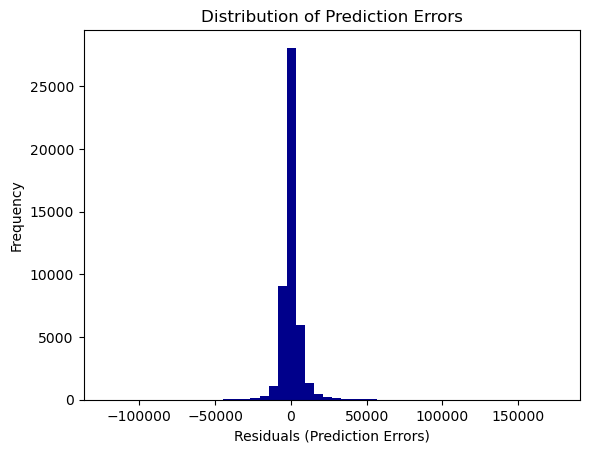

In [23]:
# Plot histogram of residuals
plt.hist(residuals, bins=50, color='darkblue')
plt.xlabel('Residuals (Prediction Errors)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.show()

In [24]:
# View the final comparison DataFrame
final_comparison_df['Residuals']=final_comparison_df['Actual Price']-final_comparison_df['Predicted Price']

final_comparison_df.sort_values(by='Residuals').head(20)

,Actual Price,Predicted Price,Year,Power,Mileage,Modell_encoded,model,Residuals
35113,24990.0,146760.728571,2018.0,585.0,21600.0,195424.454381,Mercedes-Benz G 63 AMG,-121770.728571
38616,40980.0,154837.615385,2021.0,330.0,49000.0,90569.037342,Mercedes-Benz G 400,-113857.615385
20002,19888.0,131051.800000,2016.0,630.0,25981.0,82298.449673,Mercedes-Benz S 65 AMG,-111163.800000
41180,76041.0,182524.684211,2022.0,510.0,1355.0,130226.361345,Porsche 911,-106483.684211
15158,19900.0,123522.628319,2019.0,421.0,56500.0,116712.262501,Mercedes-Benz G 500,-103622.628319
24139,79900.0,179383.000000,2009.0,695.0,26436.0,70075.129182,Bentley,-99483.000000
7928,57500.0,148043.300000,2020.0,450.0,26560.0,130226.361345,Porsche 911,-90543.300000
32254,32990.0,123522.628319,2018.0,421.0,41000.0,116712.262501,Mercedes-Benz G 500,-90532.628319
34063,26000.0,113921.010417,2019.0,522.0,30100.0,137731.099557,Mercedes-Benz AMG GT,-87921.010417
32216,5990.0,90050.000000,2008.0,605.0,980.0,41035.569892,Ford Mustang,-84060.000000


In [25]:
final_comparison_df.sort_values(by='Residuals').tail(20)

,Actual Price,Predicted Price,Year,Power,Mileage,Modell_encoded,model,Residuals
8180,115000.0,21137.669323,2015.0,184.0,150000.0,21095.198285,Mercedes-Benz E 200,93862.330677
18609,148900.0,52928.027190,2012.0,612.0,65000.0,64443.899314,Mercedes-Benz G 65 AMG,95971.972810
23377,119000.0,22468.957031,2014.0,190.0,109000.0,24191.799043,Mercedes-Benz Sprinter,96531.042969
21160,129940.0,30108.649526,2018.0,272.0,106906.0,25111.217742,Audi A6,99831.350474
26267,190000.0,90050.000000,2008.0,525.0,38500.0,31472.351593,Mercedes-Benz CL 63 AMG,99950.000000
36384,125000.0,22776.325062,2005.0,354.0,93000.0,40789.005780,Mercedes-Benz G 55 AMG,102223.674938
42002,125000.0,22776.325062,2005.0,354.0,93000.0,40789.005780,Mercedes-Benz G 55 AMG,102223.674938
5461,133000.0,30663.307775,2019.0,184.0,59500.0,21095.198285,Mercedes-Benz E 200,102336.692225
40432,129990.0,27177.788136,2007.0,340.0,163000.0,48659.178817,Mercedes-Benz S 450,102812.211864
31236,150000.0,44910.793296,2014.0,325.0,83000.0,74557.150639,Porsche Cayman,105089.206704


In [26]:
outlier_threshold = 2.5 * np.std(residuals)  # Set a threshold for residuals
outliers = outlier_df[abs(outlier_df['Residuals']) > outlier_threshold]

In [59]:
outliers

,Actual Price,Predicted Price,Residuals,Modell_encoded,Mileage,Power_ps,fuel_consumption,Abs_Residuals
37132,37500.0,72682.555556,-35182.555556,71966.401778,90000.0,600.0,10.5,35182.555556
156475,33490.0,65047.149254,-31557.149254,130226.361345,118700.0,355.0,11.8,31557.149254
116314,63900.0,44512.119921,19387.880079,51011.235632,60100.0,190.0,6.2,19387.880079
41465,54790.0,33290.102473,21499.897527,11020.443709,6000.0,136.0,7.5,21499.897527
92229,88655.0,107943.518987,-19288.518987,76451.737811,10402.0,430.0,12.0,19288.518987
...,...,...,...,...,...,...,...,...
35149,45999.0,72682.555556,-26683.555556,60843.188763,116000.0,575.0,11.1,26683.555556
179179,23590.0,52967.162791,-29377.162791,34686.154334,1555.0,245.0,6.0,29377.162791
202047,40000.0,10459.406780,29540.593220,13783.025761,57000.0,174.0,11.8,29540.593220
107766,63999.0,43962.910781,20036.089219,60330.797834,102000.0,507.0,10.8,20036.089219


/var/folders/bg/6h6fxpzx7_v6jgvd0c31r_7m0000gn/T/ipykernel_61582/1195400347.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers['price_range'] = pd.cut(outliers['Actual Price'], bins=bins, labels=labels)


  price_range  count
0        >50k    698
1     40k-50k    138
2     30k-40k    124
3     20k-30k     91
4     10k-20k     54
5        <10k     15


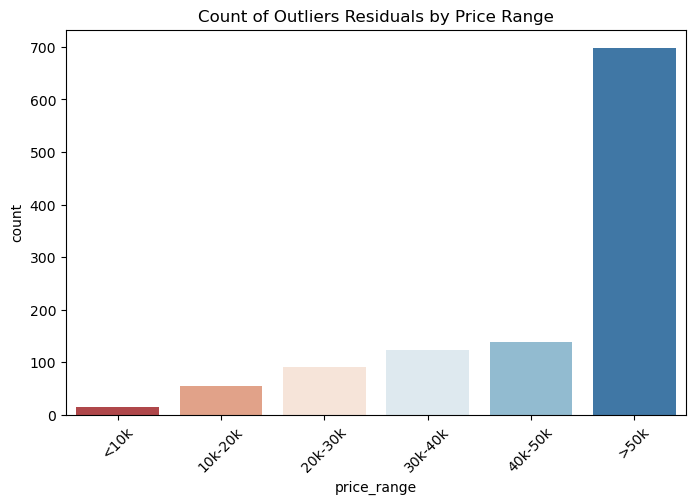

In [27]:
# Define price bins
bins = [0, 10000, 20000, 30000, 40000, 50000, float('inf')]
labels = ['<10k', '10k-20k', '20k-30k', '30k-40k', '40k-50k', '>50k']

# Create a new column for price ranges
outliers['price_range'] = pd.cut(outliers['Actual Price'], bins=bins, labels=labels)

# Group by price range
price_range_distribution = outliers['price_range'].value_counts().reset_index()
price_range_distribution.columns = ['price_range', 'count']

# Display the distribution
print(price_range_distribution)
# Visualize the price ranges
plt.figure(figsize=(8, 5))
sns.barplot(data=price_range_distribution, x='price_range', y='count', palette='RdBu')
plt.title('Count of Outliers Residuals by Price Range')
plt.xticks(rotation=45)
plt.show()

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/500 [00:00<?, ?it/s]

SHAP Values for decision tree model trained on  dataset w/o outliers


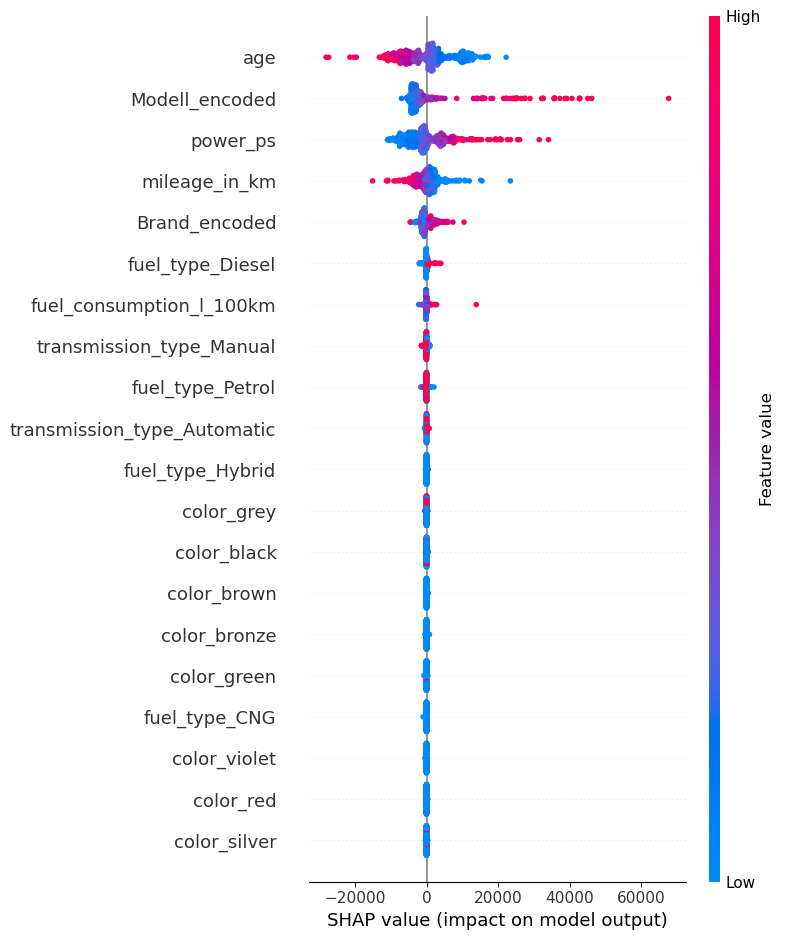

In [32]:

# Specify how many samples to use for SHAP calculations (e.g., 50 samples)
X_test_sampled = shap.sample(X_test_d, 500)
# Use the sampled data for KernelExplainer
explainer = shap.KernelExplainer(dt.predict, X_test_sampled)

# Get SHAP values for the sampled data
shap_values = explainer.shap_values(X_test_sampled)
print('SHAP Values for decision tree model trained on  dataset w/o outliers')
# Create the SHAP summary plot
shap.summary_plot(shap_values, X_test_sampled)


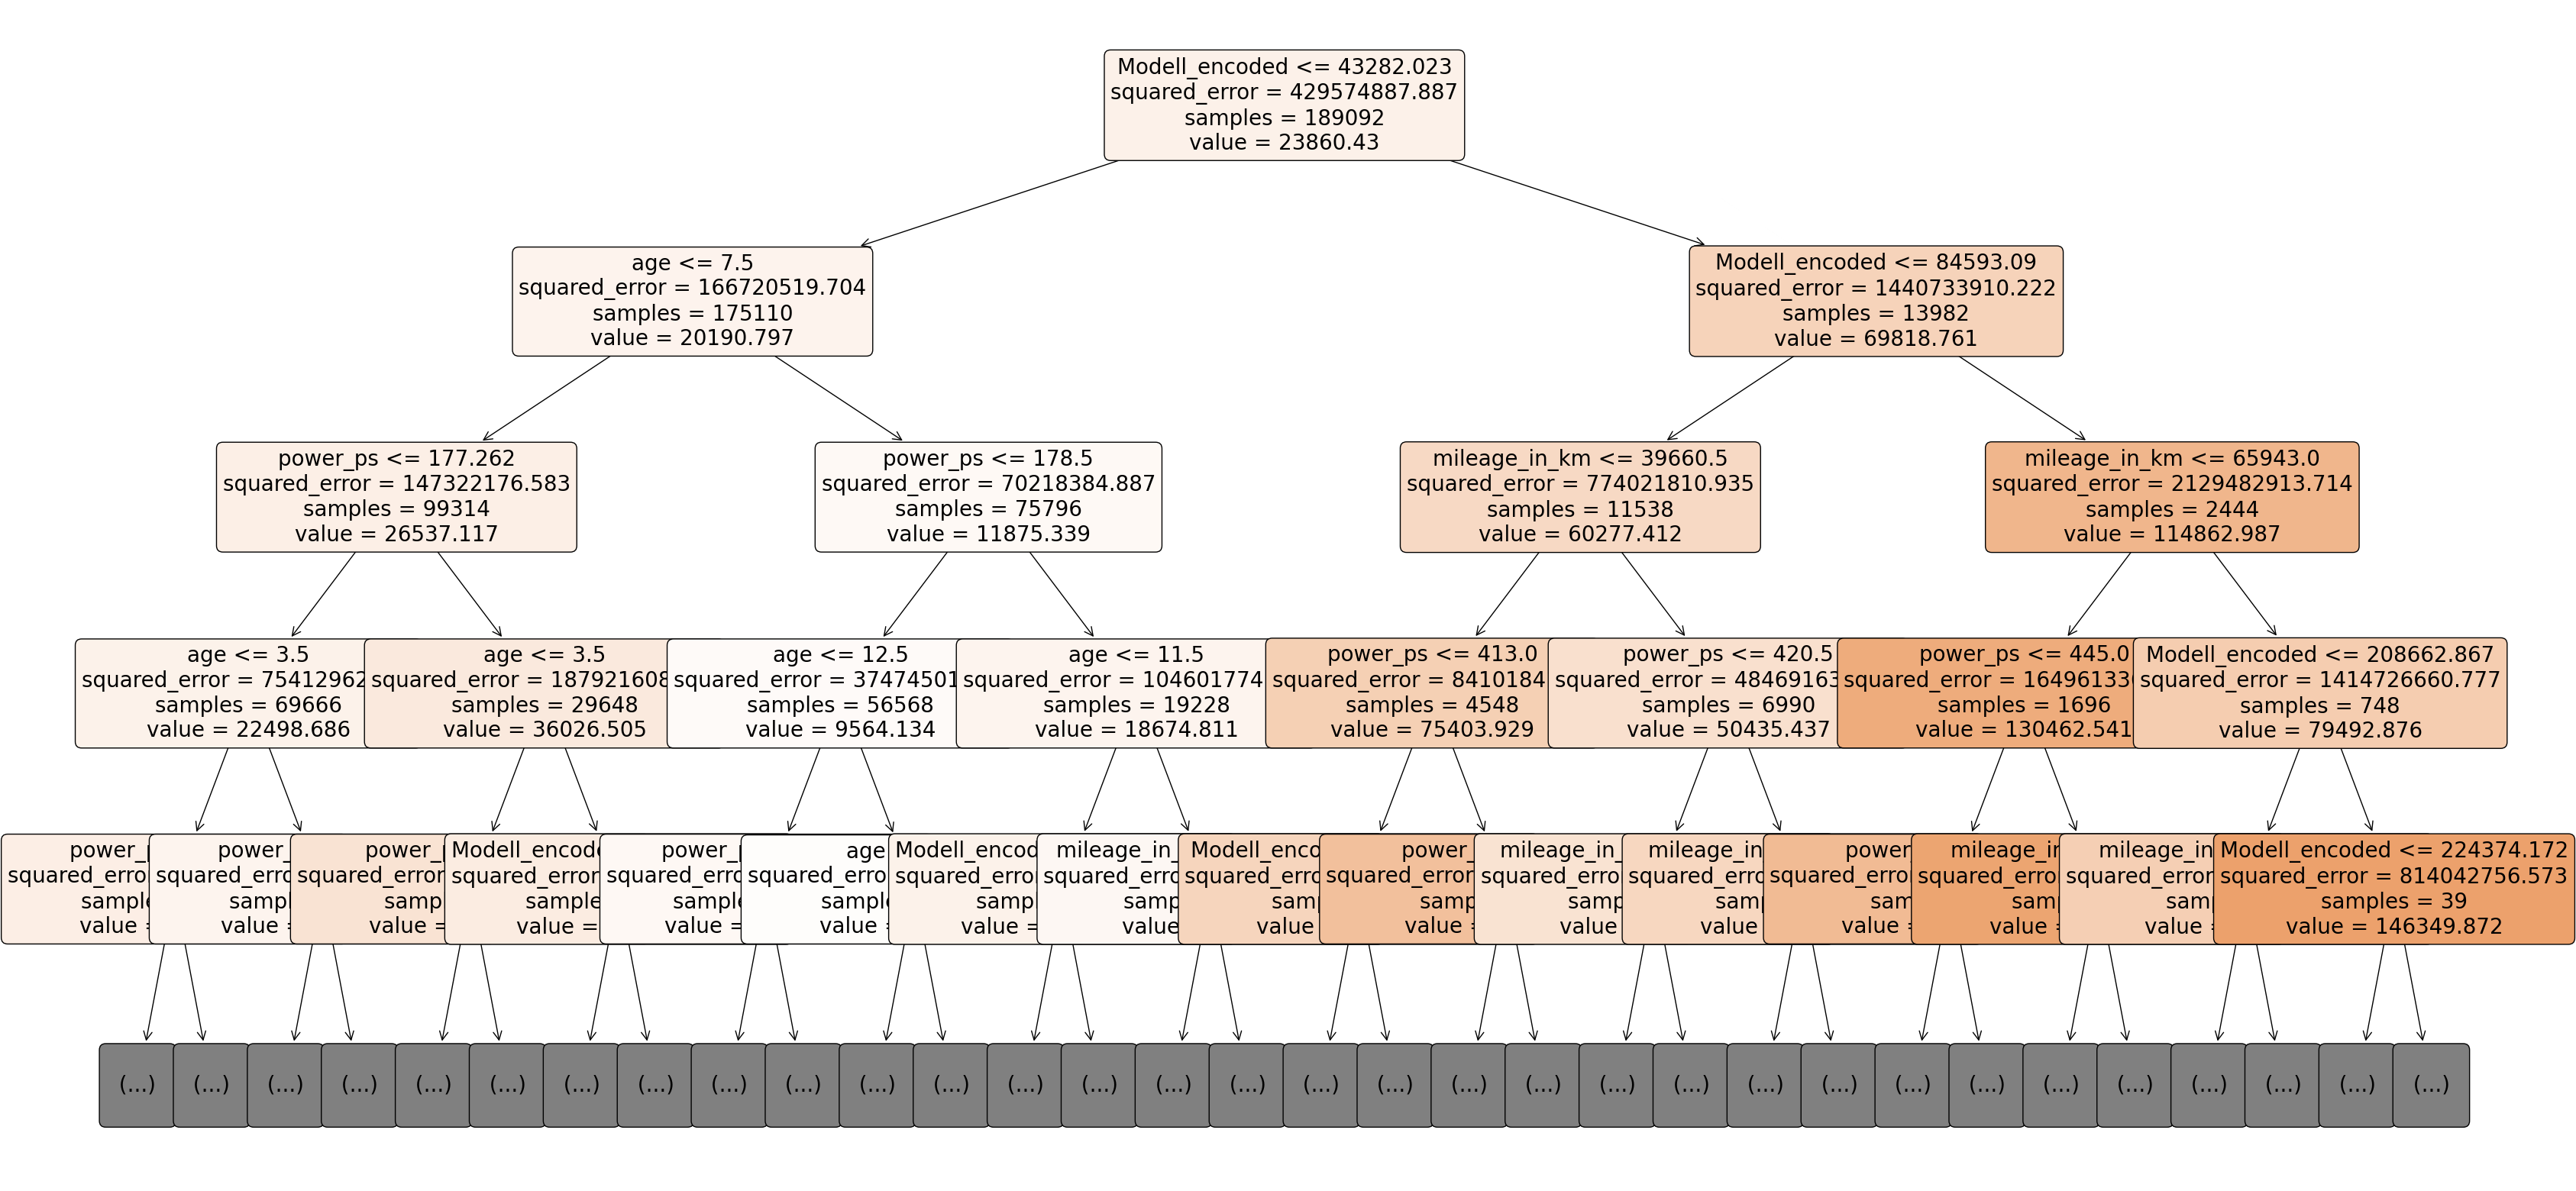

In [57]:
# Convert the feature names (from X_train.columns) to a list
feature_names = X_train.columns.tolist()

# Plot the tree with matplotlib
plt.figure(figsize=(40,20))  # Adjust the size of the plot
plot_tree(dt, 
          feature_names=feature_names,  # Pass the feature names as a list
          filled=True,                   # Color nodes based on prediction value
          rounded=True,                  # Rounded nodes for aesthetics
          fontsize=20, max_depth=4)                   # Adjust the fontsize
plt.show()